In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE
from scipy.stats import ttest_1samp


def load_data(file_name, folder_name=None):
    if folder_name != None:
        path = Path("/".join([os.getcwd(), folder_name, file_name]))
    else:
        path = Path("/".join([os.getcwd(), file_name]))
    return pd.read_csv(path)


def plot_histograms(data, target, target_figsize, dependent_layout, dependent_figsize):
    print(f"Distribution of target {target} and dependent variables:")
    data[target].hist(figsize=target_figsize, grid=False).set_title(target)
    data.drop([target], axis=1).hist(layout=dependent_layout, figsize=dependent_figsize, sharey=True, grid=False)
    plt.tight_layout();

In [2]:
file_name = "term-deposit-marketing-2020.csv"
folder_name = "data"
data = load_data(file_name, folder_name)
print(data.head(), "\n")
print(data.info(), "\n")
data.describe()

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign   y  
0  unknown    5   may       261         1  no  
1  unknown    5   may       151         1  no  
2  unknown    5   may        76         1  no  
3  unknown    5   may        92         1  no  
4  unknown    5   may       198         1  no   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object


,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


The data set consists of different data types.

Convert the type of "day" from int64 to object/categorical.

In [3]:
data['day'] = data['day'].astype(str)

Take a look at the distribution of the target variable "y" and dependent variables that are numeric.

Distribution of target y and dependent variables:


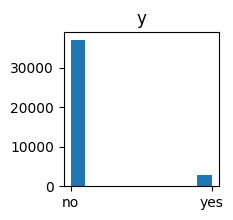

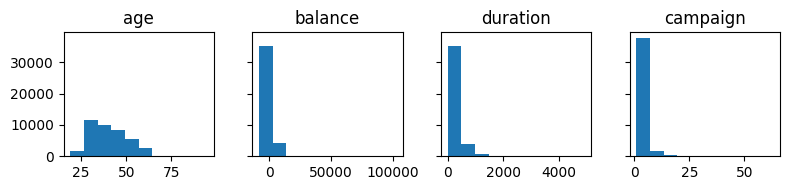

In [4]:
plot_histograms(data=data,
                target="y", target_figsize=(2,2),
                dependent_layout=(1,4), dependent_figsize=(8, 2))

The target class is highly imbalanced. SMOTE (synthetic minority oversampling technique) can be used to deal with the class imbalance.<br>
<br>
Except for age, the other numeric variables are highly skewed to the right. Also the numeric variables are in widely different scales, which will not be helpful in model training and evaluation.<br>
Thus, they will be normalized using sklearn's StandardScaler after splitting the data into train and test sets.

In [5]:
print(f"Number of dependent variables: {len(data.columns)-1}")

Number of dependent variables: 13


Since there are 13 dependent variables with different data types, we are going to look at feature importances from XGBClassifier for simplicity.<br>
<br>
Before doing so, we need to first convert categorical variables into numeric, including the target variable, so that machine learning models can process the data. panda's get_dummies method will be used for that operation.<br>
* For the target variable, manually convert "no" to 0 and "yes" to 1 without using the encoder so that "no" would not be converted to 1 instead, which would not be intuitive in practice and might cause misunderstanding.

In [7]:
X_original = data.drop(["y"], axis=1)
y_original = data["y"]
y = y_original.apply(lambda x: 1 if x=="yes" else 0)

X = pd.DataFrame()
for col in X_original.columns:
    if type(X_original[col][0]) == str:
        col_pivoted = pd.get_dummies(X_original[col], prefix=col)
        X = pd.concat([X, col_pivoted], axis=1)
    else:
        X = pd.concat([X, X_original[col]], axis=1)

X.describe()

,age,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.00000,40000.000000,...,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,0.112075,0.234575,0.035125,0.027175,0.204150,0.035925,0.035350,0.09775,0.013100,...,0.057400,0.029400,0.159500,0.118350,0.006450,0.338300,0.089950,0.002000,254.824300,2.882175
std,9.641776,0.315463,0.423738,0.184098,0.162595,0.403084,0.186106,0.184665,0.29698,0.113704,...,0.232608,0.168927,0.366146,0.323026,0.080053,0.473137,0.286114,0.044677,259.366498,3.239051
min,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,1.000000
50%,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,175.000000,2.000000
75%,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,313.000000,3.000000
max,95.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4918.000000,63.000000


Now it's time to split the data into train and test sets, and then to oversample for the target variable, which is highly imbalanced as we've observed from the histogram above, for the train and test sets separately to prevent data leakage.

In [8]:
test_size = 0.2
random_state = 1
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

In [9]:
X_train_oversampled, y_train_oversampled = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
X_test_oversampled, y_test_oversampled = SMOTE(random_state=random_state).fit_resample(X_test, y_test)

Next is normalizing the dependent variables in different scales using sklearn's StandardScaler as mentioned above.<br>
* Normalization is not necessary for the target variable but rename the "X/y_test_oversampled" variables to "X/y_test_oversampled" to prevent confusion.

In [10]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_oversampled)
X_test_normalized = scaler.transform(X_test_oversampled)

y_train_normalized = y_train_oversampled
y_test_normalized = y_test_oversampled

In [11]:
xgb_clf = XGBClassifier(seed=random_state)
xgb_clf.fit(X_train_normalized, y_train_normalized)
accuracy_score(y_test_normalized, xgb_clf.predict(X_test_normalized))

0.9605174504783722

In [12]:
scores = cross_val_score(xgb_clf, X_test_normalized, y_test_normalized, scoring='roc_auc',
                         cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=100))

Hypothesis test for XGBClassifier
Reject the null hypothesis:
Mean test score is greater than 0.81 at alpha=0.05.



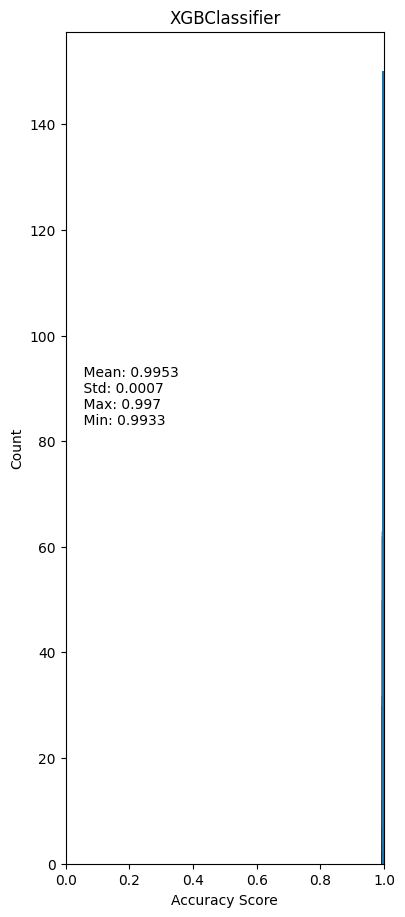

In [15]:
target = 0.81
alpha = 0.05

fig, ax = plt.subplots(figsize=(5, 10))
fig.tight_layout(pad=5)
print(f"Hypothesis test for {type(xgb_clf).__name__}")
t_stat, pvalue = ttest_1samp(scores, target)
if pvalue/2 > alpha:
    print(f"Failed to reject the null hypothesis:")
    print(f"Mean test score is not significantly different from {target} at alpha={alpha}.")
else:
    print(f"Reject the null hypothesis:")
    if t_stat > 0:
        print(f"Mean test score is greater than {target} at alpha={alpha}.")
    else:
        print(f"Mean test score is smaller than {target} at alpha={alpha}.")
print()

sns.histplot(scores, ax=ax)
ax.vlines(np.mean(scores), 0, 150)
ax.text(0, 80,
    f"""
    Mean: {round(np.mean(scores), 4)}
    Std: {round(np.std(scores), 4)}
    Max: {round(np.max(scores), 4)}
    Min: {round(np.min(scores), 4)}
    """)
ax.set_title(type(xgb_clf).__name__)
ax.set_xlabel("Accuracy Score")
ax.set_xbound(0, 1)

The prediction accuracy scores were almost perfect, likely becuase the preprocessing steps performed before model fitting such as normalizing dependent variables in different scales helped a lot.

In [14]:
xgb_clf.feature_importances_

array([0.00129588, 0.0056054 , 0.01061742, 0.00582657, 0.00548151,
       0.01063287, 0.00548122, 0.00480713, 0.00977681, 0.00353171,
       0.01155604, 0.00619368, 0.0024687 , 0.0693954 , 0.01684836,
       0.02767983, 0.02631562, 0.0126255 , 0.02100228, 0.03894221,
       0.00126845, 0.0010093 , 0.0015009 , 0.09871136, 0.12073225,
       0.01012163, 0.01986355, 0.00555588, 0.01651951, 0.08103521,
       0.00169077, 0.00366467, 0.00374191, 0.00155264, 0.00142494,
       0.00266061, 0.0024435 , 0.00206698, 0.00440258, 0.00170805,
       0.00252832, 0.00358921, 0.00341658, 0.00150453, 0.00184903,
       0.00122723, 0.00098199, 0.00235714, 0.00117496, 0.00133296,
       0.00295072, 0.00191067, 0.00401177, 0.00240923, 0.00123877,
       0.00370291, 0.0034287 , 0.00407589, 0.00385777, 0.00240045,
       0.00203104, 0.01596044, 0.05250814, 0.        , 0.01176248,
       0.0360489 , 0.03226461, 0.01517027, 0.00144849, 0.02475934,
       0.03715429, 0.00850193, 0.03125125, 0.00343104], dtype=